# UR10 Calibration
- Step-by-step introduction to `pybotics`
- Simplified calibration of UR10 industrial collaborative robot

## Imports

In [1]:
# pybotics
from pybotics import Robot, KinematicChain, LinkConvention, RobotOptimizationMask, Tool, Frame
from pybotics.calibration import compute_absolute_errors
from pybotics.constants import TRANSFORM_MATRIX_SHAPE, POSITION_VECTOR_LENGTH, TRANSFORM_VECTOR_LENGTH

# essentials
import numpy as np
import pandas as pd
from copy import deepcopy

# optimization
import scipy.optimize
from sklearn.model_selection import train_test_split

# plotting
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline  

# printing options
np.set_printoptions(suppress=True)
pd.set_option('precision', 3)

## Optimization Function
- Computes the errors between a robot model and the measured positions (i.e., real life)
    - Requires a series of measured joint-position pairs
        - Joints = random robot configurations
        - Positions = measured real-world Cartesian positions with a laser tracker

In [2]:
def fitness_function(optimization_vector, robot, joints, positions):
    """Return absolute distance errors of a given robot model from corresponding joints and positions."""
    
    # apply latest optimization vector     
    robot.apply_optimization_vector(optimization_vector)
    
    # compute absolute errors
    # errors = abs(calculated fk - actual position)     
    errors = compute_absolute_errors(robot, joints, positions)
    
    return errors

# World Frame
- Describes the geometric transformation between our global reference frame and the base of the robot
    - Here:
        - Global reference frame = laser tracker's origin
        - Assumed to be well defined

In [3]:
world_frame = np.array(
    [-0.910397, 0.413555, -0.012223, 2289.101393,
     -0.413474, -0.910475, -0.008638, 36.666412,
     -0.014701, -0.002810, 0.999888, -899.473355,
     0, 0, 0, 1]
).reshape(TRANSFORM_MATRIX_SHAPE)

display(world_frame)

array([[   -0.910397,     0.413555,    -0.012223,  2289.101393],
       [   -0.413474,    -0.910475,    -0.008638,    36.666412],
       [   -0.014701,    -0.00281 ,     0.999888,  -899.473355],
       [    0.      ,     0.      ,     0.      ,     1.      ]])

# Tool Frame
- Describes the geometric transformation between our robot flange and the tool centre point (TCP)
    - TCP = centre of spherically mounted retroreflector (SMR)
- Derived from mechanical CAD measurements

In [4]:
tool_frame = np.array(
    [1, 0, 0, -31.418407,
     0, 1, 0, -119.737717,
     0, 0, 1, 27.368691,
     0, 0, 0, 1]
).reshape(TRANSFORM_MATRIX_SHAPE)

display(tool_frame)

array([[   1.      ,    0.      ,    0.      ,  -31.418407],
       [   0.      ,    1.      ,    0.      , -119.737717],
       [   0.      ,    0.      ,    1.      ,   27.368691],
       [   0.      ,    0.      ,    0.      ,    1.      ]])

# Measured Tool Frame Poses
- Calibrate the tool frame
- Simple poses that just rotate the last three joints (i.e., robot wrist)
    - Minimize sources of error

In [5]:
tool_df = pd.read_csv('tool.csv')

display(tool_df)

,joint_0,joint_1,joint_2,joint_3,joint_4,joint_5,laser_x,laser_y,laser_z
0,90,-90,90,0,-30,0,1800.732,406.872,-406.413
1,90,-90,90,0,0,0,1774.976,465.445,-406.164
2,90,-90,90,0,30,0,1781.964,529.086,-405.476
3,90,-90,90,0,0,-30,1752.478,516.228,-374.215
4,90,-90,90,0,0,0,1774.973,465.446,-406.169
5,90,-90,90,0,0,30,1800.434,406.647,-406.076
6,90,-90,90,0,0,0,1774.963,465.474,-406.162


In [6]:
# split df into inputs/outputs
tool_joints = tool_df[['joint_{}'.format(i) for i in range(6)]]
tool_positions = tool_df[['laser_{}'.format(i) for i in 'xyz']]

# pybotics uses radians
tool_joints = np.deg2rad(tool_joints)

# Measured Robot Poses
- Calibrate the robot kinematic chain (i.e., MDH parameters)
- Many random robot configurations (i.e., joints) are measured

In [7]:
robot_df = pd.read_csv('ur10.csv')

display(robot_df.head())
display(robot_df.tail())

,joint_0,joint_1,joint_2,joint_3,joint_4,joint_5,laser_x,laser_y,laser_z,tool_x,tool_y,tool_z
0,141.158,-56.026,16.648,26.515,71.239,74.703,1329.845,-40.650,-76.294,-31.418,-119.738,27.369
1,113.155,-38.278,29.866,156.538,-28.555,3.794,1388.183,462.718,-104.241,-31.418,-119.738,27.369
2,80.101,-45.366,27.095,60.263,-14.974,-68.352,1742.167,875.745,-321.800,-31.418,-119.738,27.369
3,159.618,-10.312,27.396,139.321,-96.898,16.232,1136.559,-196.619,-587.373,-31.418,-119.738,27.369
4,74.023,-24.307,34.791,39.111,-18.101,3.256,1867.326,915.997,-774.333,-31.418,-119.738,27.369


,joint_0,joint_1,joint_2,joint_3,joint_4,joint_5,laser_x,laser_y,laser_z,tool_x,tool_y,tool_z
146,128.119,-33.365,73.789,115.324,-41.703,63.009,1307.882,322.416,-581.836,-31.418,-119.738,27.369
147,168.337,-45.826,43.306,-13.215,105.359,-53.426,1195.157,-235.826,-464.456,-31.418,-119.738,27.369
148,80.145,-56.789,49.528,53.370,-9.567,-101.961,1759.802,848.527,-302.431,-31.418,-119.738,27.369
149,132.957,-69.031,66.650,-13.151,68.842,41.114,1315.753,155.694,-388.257,-31.418,-119.738,27.369
150,70.734,-67.434,33.176,39.382,-17.825,27.201,1952.649,628.436,-121.983,-31.418,-119.738,27.369


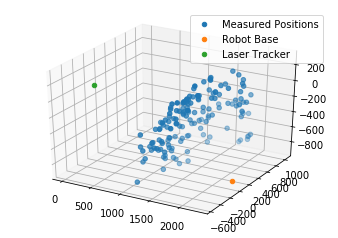

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# plot 
ax.scatter(robot_df['laser_x'],robot_df['laser_y'],robot_df['laser_z'],label='Measured Positions');
ax.scatter(world_frame[0, -1],world_frame[1, -1],world_frame[2, -1],label='Robot Base');
ax.scatter(0,0,0,label='Laser Tracker');

ax.legend();
ax.set_aspect('equal');

- Bias towards region between laser tracker and robot base
- Good enough for a demo! 😛

In [9]:
# split df into inputs/outputs
robot_joints = robot_df[['joint_{}'.format(i) for i in range(6)]]
robot_positions = robot_df[['laser_{}'.format(i) for i in 'xyz']]

# pybotics uses radians
robot_joints = np.deg2rad(robot_joints)

## Split Testing and Training Data
- Put aside a set of measures for validation after calibration
- Prevent overfitting

In [10]:
train_robot_joints, \
test_robot_joints, \
train_robot_positions, \
test_robot_positions = train_test_split(robot_joints,
                                        robot_positions,
                                        test_size=0.3)

## Nominal Model
- Represents the manufacturer's intended mathematical model for the robot

In [11]:
# load UR10 kinematic chain (i.e., MDH parameters)
mdh = np.loadtxt('ur10-mdh.csv', delimiter=',')
kc = KinematicChain.from_array(mdh)

# construct nominal robot
nominal_robot = Robot(kc)
nominal_robot.world_frame = Frame(world_frame)
nominal_robot.tool = Tool(tool_frame)

display(pd.DataFrame(
        nominal_robot.kinematic_chain.vector.reshape(nominal_robot.num_dof,-1),
        columns=('alpha', 'a', 'theta', 'd')))

,alpha,a,theta,d
0,0.000,0.0,0.000,118.0
1,1.571,0.0,3.142,0.0
2,0.000,612.7,0.000,0.0
3,0.000,571.6,0.000,163.9
4,-1.571,0.0,0.000,115.7
5,1.571,0.0,3.142,92.2


## Initial Errors
- What would the offline programming errors look like if we did not calibrate the robot?

In [12]:
nominal_errors = compute_absolute_errors(nominal_robot, test_robot_joints, test_robot_positions)

display(pd.Series(nominal_errors).describe())

count    46.000
mean      2.666
std       0.634
min       1.081
25%       2.251
50%       2.667
75%       3.001
max       4.350
dtype: float64

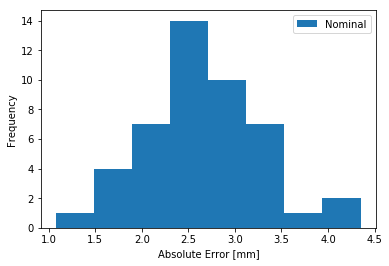

In [13]:
plt.figure()

plt.hist(x=nominal_errors,
         label='Nominal',
         bins='auto');

plt.xlabel('Absolute Error [mm]');
plt.ylabel('Frequency');
plt.legend();

- Ouch! Pretty large errors!
- Don't forget, these are real measurements of a real industrial (expensive) robot!

## Tool Calibration
- Poorly designed and measured tooling often has a large error contribution
- Simply screwing a tool to a robot isn't that accurate...

In [14]:
# create a robot copy for tool calibration
tool_calibration_robot = deepcopy(nominal_robot)

In [15]:
# we are only going to calibrate 
# the tool centre point position (TCP) not orientation
tool_mask = [False] * TRANSFORM_VECTOR_LENGTH

for i in range(POSITION_VECTOR_LENGTH):
    tool_mask[i] = True

tool_calibration_robot.optimization_mask \
    = RobotOptimizationMask(world_frame=False,
                            kinematic_chain=False,
                            tool=tool_mask)

In [16]:
# scipy to the rescue!
# minimize the error of the tool_calibration_robot model
result = scipy.optimize.leastsq(func=fitness_function,
                                x0=tool_calibration_robot.optimization_vector,
                                args=(tool_calibration_robot,
                                      tool_joints,
                                      tool_positions))

# apply the solution vector to the model
tool_calibration_robot.apply_optimization_vector(result[0])

# optimized tool frame
display(tool_calibration_robot.tool.matrix)

array([[   1.        ,    0.        ,    0.        ,  -32.78366082],
       [  -0.        ,    1.        ,    0.        , -119.1872499 ],
       [   0.        ,   -0.        ,    1.        ,   27.41458655],
       [   0.        ,    0.        ,    0.        ,    1.        ]])

In [17]:
# diff vs old frame
display(tool_calibration_robot.tool.matrix - tool_frame)

array([[ 0.        ,  0.        ,  0.        , -1.36525382],
       [-0.        ,  0.        ,  0.        ,  0.5504671 ],
       [ 0.        , -0.        ,  0.        ,  0.04589555],
       [ 0.        ,  0.        ,  0.        ,  0.        ]])

- Even with our well design tool and CAD measurements, the actual tool was off by a few mm

## Robot Calibration

In [18]:
# make a new robot copy
calibration_robot = deepcopy(tool_calibration_robot)

In [19]:
# init the optimization mask
mask = np.array(calibration_robot.kinematic_chain.optimization_mask) \
        .reshape((calibration_robot.num_dof, -1))
mask[:] = True

# filter out a couple of redundant parameters
# outside the scope of the presentation
mask[1:3, -1] = False
display(mask)

# apply mask to robot
# filter out world/tool calibrations
calibration_robot.optimization_mask \
    = RobotOptimizationMask(world_frame=False,
                            kinematic_chain=mask.ravel(),
                            tool=False)

array([[ True,  True,  True,  True],
       [ True,  True,  True, False],
       [ True,  True,  True, False],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True]], dtype=bool)

In [20]:
# maxfev is set way lower than it should for a quick demo
result = scipy.optimize.leastsq(func=fitness_function,
                                x0=calibration_robot.optimization_vector,
                                maxfev=50,
                                args=(calibration_robot,
                                      train_robot_joints,
                                      train_robot_positions))

# apply the solution vector to the model
calibration_robot.apply_optimization_vector(result[0])

/usr/local/lib/python3.6/site-packages/scipy/optimize/minpack.py:427: RuntimeWarning: Number of calls to function has reached maxfev = 50.
  warnings.warn(errors[info][0], RuntimeWarning)


In [21]:
new_model = calibration_robot \
            .kinematic_chain \
            .vector \
            .reshape(calibration_robot.num_dof,-1)

display(pd.DataFrame(new_model,
        columns=('alpha', 'a', 'theta', 'd')))

,alpha,a,theta,d
0,3.532e-06,0.334,4.992e-04,118.258
1,1.572e+00,-0.204,3.139e+00,0.000
2,-7.380e-04,613.103,2.124e-03,0.000
3,1.952e-03,571.667,-2.174e-03,164.354
4,-1.572e+00,-0.225,1.637e-02,115.762
5,1.571e+00,0.079,3.154e+00,91.696


In [22]:
old_model = nominal_robot \
            .kinematic_chain \
            .vector \
            .reshape(nominal_robot.num_dof,-1)

display(pd.DataFrame(new_model - old_model,
        columns=('delta alpha', 'delta a',
                 'delta theta', 'delta d')))

,delta alpha,delta a,delta theta,delta d
0,3.532e-06,0.334,4.992e-04,0.258
1,1.086e-03,-0.204,-2.157e-03,0.000
2,-7.380e-04,0.403,2.124e-03,0.000
3,1.952e-03,0.067,-2.174e-03,0.454
4,-8.295e-04,-0.225,1.637e-02,0.062
5,5.975e-05,0.079,1.265e-02,-0.504


- Little errors here and there through the model

## Error Improvement

In [23]:
calibrated_errors = compute_absolute_errors(calibration_robot,
                                            test_robot_joints,
                                            test_robot_positions)

display(pd.Series(calibrated_errors).describe())

count    46.000
mean      0.232
std       0.130
min       0.044
25%       0.142
50%       0.213
75%       0.310
max       0.612
dtype: float64

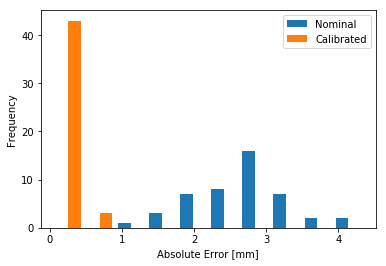

In [24]:
plt.figure()

plt.hist(x=[nominal_errors,calibrated_errors],
         label=['Nominal', 'Calibrated'],
         bins=10);

plt.xlabel('Absolute Error [mm]');
plt.ylabel('Frequency');
plt.legend();

![](doge-accuracy.png)

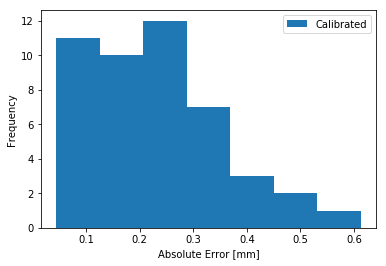

In [25]:
# more zoom!
plt.figure()

plt.hist(x=calibrated_errors,
         label='Calibrated',
         bins='auto');

plt.xlabel('Absolute Error [mm]');
plt.ylabel('Frequency');
plt.legend();